In [9]:
from demodulation import *
#
import decoding as decode
import scipy
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write, read
from scipy.signal import correlate
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
from sklearn.preprocessing import minmax_scale
import os
import math

In [10]:
SYNC_FREQ = [[348, 894], [5298, 5792]]

### Record or read

3662064


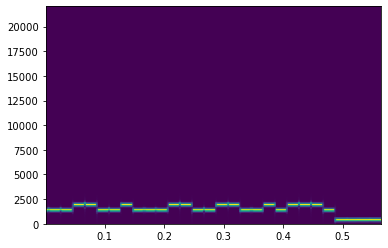

In [13]:
filename = os.path.join('D:\GitHub\EL5207_project\\2img_2txt_sync.wav')
# listen
# record(2, SAMPLE_FREQ, filename) 
# read
fs, audio = read(filename)
print(len(audio)) 
wave0 = filter_freq(audio, SYNC_FREQ[0][0], 100, SAMPLE_FREQ)
wave1 = filter_freq(audio, SYNC_FREQ[0][1], 100, SAMPLE_FREQ)
wave_sum = wave0 + wave1
spectrum, freqs, t, im = plt.specgram(audio[-25000:], Fs = SAMPLE_FREQ, scale = 'linear')
plt.show()

In [4]:
def get_two_max_indices(arr):
    sorted_indices = np.argsort(arr)
    max_indices = sorted_indices[-2:]
    return max_indices

In [5]:
# build the start and end signal
def bfsk_modulate(bit_array, space_freq, mark_freq, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    space = np.sin(space_freq * 2 * np.pi * t)
    mark = np.sin(mark_freq * 2 * np.pi * t)
    signal = np.array([])
    for bit in bit_array:
        if bit == 0:
            signal = np.append(signal, space)
        elif bit == 1:
            signal = np.append(signal, mark)
    return signal

ref = bfsk_modulate([1,1,0,0], 348, 894, 16, 44100)

In [6]:
def sync_detect(audio, sync_freq, mode = "img"):
    # Filter in the frequency
    wave0 = filter_freq(audio, sync_freq[0], 50, SAMPLE_FREQ)
    wave1 = filter_freq(audio, sync_freq[1], 50, SAMPLE_FREQ)
    wave_sum = wave0 + wave1
    # get the reference
    ref_init = bfsk_modulate([1, 1, 1, 1], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    ref_end = bfsk_modulate([0, 0, 0, 0], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    # From this we get the peaks
    start = 0
    end = 0
    #
    corr_init = []
    corr_end = []
    for i in range(math.floor((len(wave_sum))/len(ref_init))):
        y_w = wave_sum[i* len(ref_init):(i+1) * len(ref_init)]
        cor = correlate(ref_init, y_w, mode='full', method='fft')
        corr_init.append(sum(cor**2))
        y_x = wave_sum[i* len(ref_end):(i+1) * len(ref_end)]
        cor = correlate(ref_end, y_x, mode='full', method='fft')
        corr_end.append(sum(cor**2)) 
    # return audio[start:end]
    if (mode == "img"):
        start = np.min(get_two_max_indices(corr_init))
        end = np.min(get_two_max_indices(corr_init))
    else: # text
        start = np.max(get_two_max_indices(corr_init))
        end = np.max(get_two_max_indices(corr_end))
        print(end)
    # print(start, end)
    # Get the location in sample points
    samples_per_bit = int(SAMPLE_FREQ / BAUD)
    start = int((start + 1)*samples_per_bit*4)
    end = int((end)*samples_per_bit*4)
    plt.plot(corr_init)
    plt.show()
    plt.plot(corr_end)
    plt.show()
    # print(start, end)
    # print(len(audio) - start)
    return audio[start:end]

In [ ]:
# 1111-img-00001111-txt-0000

863


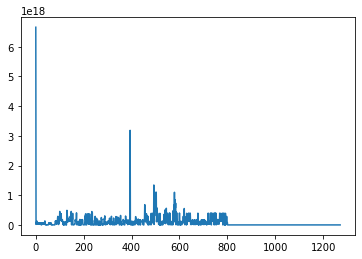

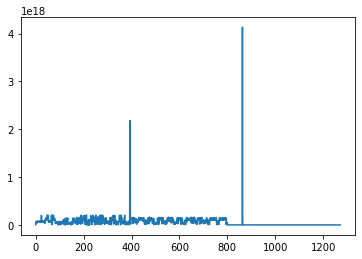

In [8]:
SYNC_FREQ = [[348, 894], [5298, 5792]] 
wave = sync_detect(audio, SYNC_FREQ[1], mode = "text")

In [43]:
import numpy as np

def get_two_max_indices(arr):
    sorted_indices = np.argsort(arr)
    max_indices = sorted_indices[-2:]
    return max_indices

# Example usage
my_array = np.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5])
max_indices = get_two_max_indices(my_array)

print("Indices of the two maximum values:", np.max(max_indices))
type(np.max(max_indices))

Indices of the two maximum values: 7


numpy.int64